# Эксперименты с временным рядом стоимости алюминия с моделью Random forest

In [1]:
import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 60)
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import torch
from darts import TimeSeries
from darts.metrics import mape
from darts.models import RandomForest
from darts.dataprocessing.transformers import Scaler

from datetime import timedelta
from copy import deepcopy
import random

In [2]:
import optuna
from functools import partial

## Data

In [3]:
FORECAST_LEN = 4 # Длина прогноза
OUT_OF_TIME_DIM = 20 # Размер отложенной выборки

In [4]:
def set_seed(seed: int = 42):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed)
    
set_seed()

In [5]:
df = pd.read_csv('prepared_dataset_al.csv', parse_dates=[0], dtype='float32')
print('Shape:', df.shape)

Shape: (282, 67)


In [6]:
df.describe()

,bloomberg_metals_price_mean_4,chalco_adj_std_13,usa_inflation_value_shift_13,usd_to_hkd_increment_by_mean_26,rual_price_std_26,ftse_index_std_13,hongqiao_adj_std_4,alcoa_price_std_4,norsk_hydro_adj_std_4,bloomberg_metals_price_std_9,chalco_price_std_4,eu_inflation_value_increment_by_mean_26,ftse_index_std_4,USD_JPY_rate_increment_by_mean_26,ftse_index_change_mean_52,eu_inflation_value_std_13,rual_price_std_13,baltic_dry_index_std_9,export_australia_value_std_26,australia_pmi_std_26,sp_metals_price_std_4,bloomberg_metals_price_std_4,USD_EUR_rate_std_26,import_usa_value_std_13,export_usa_value_std_9,guinea_inflation_std_26,sp_metals_price_std_9,usa_gdp_increment_value,norsk_hydro_adj_increment_by_mean_26,rual_price_std_4,...,log10_kaiser_volume_std_9,brazil_inflation_std_26,log10_kaiser_volume_std_4,mosexchange_value_std_4,shanghai_index_std_4,import_brazil_value_std_26,import_usa_value_increment_by_mean_26,ftse_index_change_std_13,guinea_inflation_std_13,export_usa_value_std_26,export_usa_value_increment_by_mean_26,USD_EUR_rate_std_13,ftse_index_change_mean_26,export_brazil_value_std_13,sp_metals_change_std_9,rual_price_change_mean_26,export_brazil_value_increment_by_mean_26,rual_price_change_std_26,rual_price_change_std_13,china_pmi2_value_std_13,log10_alcoa_volume_std_13,log10_alcoa_volume_std_9,export_china_value_increment_by_mean_26,covid,after_feb,lme_price_smooth,target_1,target_2,target_3,target_4
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,...,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,2.820000e+02,282.000000,282.000000,282.000000,281.000000,280.000000,279.000000,278.000000
mean,138.559113,0.319516,0.309423,-0.000843,4.249986,273.543396,0.259927,1.800147,1.449233,4.563441,0.168945,0.227759,139.332413,1.663174,0.111457,0.181089,2.888936,264.172943,38.807678,1.468726,61.469463,2.826630,0.015950,130076.195312,143881.859375,0.477580,95.824181,2.179436,1.091418,1.485700,...,0.181229,0.768479,0.155476,171.235138,54.980236,18.217363,17068.943359,1.026909,0.329527,260680.625000,3.658002e+04,0.010979,0.086928,11.451565,0.859504,0.069141,1.836829,1.367122,1.222799,1.929837,0.131023,0.120998,4.268951e+04,0.228467,0.162726,2187.586670,-0.311324,-0.602007,-0.583585,-0.399618
std,27.089277,0.184627,0.315599,0.019017,2.630195,177.179459,0.196332,1.611941,1.076748,3.385589,0.137156,0.419358,106.679466,4.338950,0.205780,0.113887,2.095899,173.432083,11.945754,0.910203,42.420738,2.543974,0.008652,86156.429688,199285.578125,0.447644,59.999840,3.307303,5.963383,1.465832,...,0.074597,0.416949,0.079136,149.405640,60.812988,7.940274,280205.500000,0.880100,0.404302,222130.921875,3.697457e+05,0.006033,0.254548,7.060465,0.334876,0.259328,17.119184,0.726316,0.823724,2.333842,0.064236,0.058733,3.875421e+05,0.388796,0.300243,440.553650,54.538860,88.763176,113.060982,135.670944
min,92.510361,0.052547,-0.800000,-0.061387,0.997777,54.833698,0.012340,0.180923,0.099812,0.709486,0.013164,-0.456593,17.186796,-9.918187,-0.298297,0.000000,0.633519,32.954060,20.460823,0.315536,1.132393,0.132410,0.004820,13935.265625,4.350456,0.047933,25.982565,-7.500000,-17.344406,0.151132,...,0.062280,0.075746,0.025223,11.993413,3.007912,5.112617,-739684.187500,0.358280,0.000000,34.463089,-1.048385e+06,0.003077,-0.383544,1.025469,0.357106,-0.644664,-45.708199,0.519534,0.443797,0.123188,0.063388,0.044006,-2.087662e+06,0.000000,0.000000,1479.717651,-250.823135,-405.278900,-482.037415,-501.510193
25%,115.814018,0.181782,0.114286,-0.007432,2.388422,157.340839,0.104818,0.797250,0.685221,2.282125

In [7]:
# Извлекаем временной ряд с ценами на медь
data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
# Извлекаем коварианты
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=df.columns.values[1:-5])
# Возьмем срез данных для всего процесса развития модели ts & past_cov и out-of-time выборку
ts = data_ts[:-OUT_OF_TIME_DIM]
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]
# Размер выборки out-of-time = 26 точек (то есть 26 недель = 6 месяцев)
# out-of-time выборка будет использована лишь в самом конце

In [8]:
import datetime

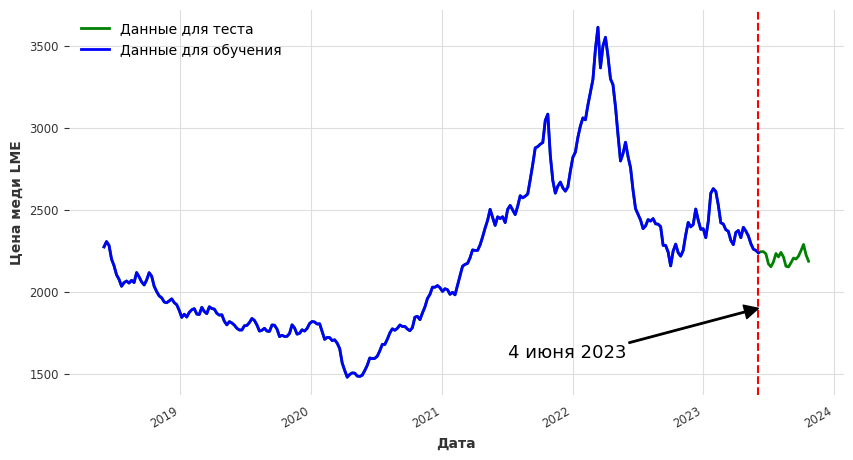

In [9]:
# Рисуем
# Рисуем
fig, ax = plt.subplots(figsize=(10, 5))
data_ts.plot(label="Данные для теста", color='g')
ts.plot(label="Данные для обучения", color='b')
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.annotate('4 июня 2023', xy=(ts.end_time(), 1900), xytext=(ts.end_time() - datetime.timedelta(700), 1600),
            arrowprops=dict(facecolor='black', width=1, headwidth=10, headlength=10), fontsize = 13
            )
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
#plt.savefig('preview.png', dpi=400, format='png')

## Tools

### Cross-validation

In [10]:
# Использовать backtest нет смысла, так как в нем не реализована функция трансформации данных (Scaler)
# Судя по github darts на октябрь 2023 идет разработка данного модуля

# average_error = tcn_model.backtest(
#     series = ts_train,
#     past_covariates=
#     start=0.5,
#     forecast_horizon=17,
#     stride = 9
#     metric=mape,
#     reduction=np.mean,  # this is actually the default
#     retrain = True
#     verbose=True,
# )

# print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

Так как backtest не работает, пропишем ручную версию  
В ручной версии подразумевается обучение модели с нуля на каждом шаге

In [38]:
def manual_backtest(model, ts, past_covariates, forecast_horizont=FORECAST_LEN, 
                    start_test=170, step = 5, save_curves=False,
                    rolling_window=False, window_size=None):
    '''
    Функция аналогична встроенной функции backtest
    '''
    metrics = list() # Список для метрик
    prediction_curves = dict() # Список для последюущей визуализации кривых
    k=1
    # Скользящее или расширяющееся окно
    if rolling_window: 
        start_train = start_test - window_size
    else:
        start_train=0
    while True:
        print('Iter #', k)
        cur_train = ts[start_train : start_test]
        cur_test = ts[start_test : start_test + int(forecast_horizont)]
        # Инициализация scaler-ов
        scaler_ts, scaler_past_cov = Scaler(), Scaler()
        # Есть ли экзогенные признаки
        if past_covariates is not None:
            past_cov_train = past_covariates[start_train : start_test]
            past_cov_test = past_covariates[start_test : start_test + int(forecast_horizont)]
            
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            past_cov_test_scaled = scaler_past_cov.transform(past_cov_test)
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled,
                        past_covariates=past_cov_train_scaled)
            cur_pred_scaled = model1.predict(int(forecast_horizont),
                                             series=cur_train_scaled,
                                             past_covariates=past_cov_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Если экзогенных признаков нет  
        else:
            cur_train_scaled = scaler_ts.fit_transform(cur_train)
            cur_test_scaled = scaler_ts.transform(cur_test)
            
            model1 = deepcopy(model)
            model1.fit(series=cur_train_scaled)
            cur_pred_scaled = model1.predict(int(forecast_horizont),
                                             series=cur_train_scaled)
            cur_pred = scaler_ts.inverse_transform(cur_pred_scaled)
        # Вычисляем метрику и добавляем в список   
        metric = mape(cur_test, cur_pred, intersect=True)
        metrics.append(metric)
        # n_epochs.append(model1.epochs_trained)
        # При необходимости можно собирать информацию о количестве эпох обучения
        # Добавляем спрогнозированную кривую в набор кривых для последующей отрисовки
        prediction_curves['pred_'+str(k)]=cur_pred
        k+=1
        
        start_test+=step
        if rolling_window:
            start_train+=step
        if start_test + int(forecast_horizont) >= len(ts):
            break
            
    if save_curves==True:
        return metrics, prediction_curves
    else:
        return metrics

### Hyperparameter optimization (optuna)

In [12]:
def objective(trial, ts, past_cov, forecast_len = FORECAST_LEN):
    
    settings = {
        "lags" : trial.suggest_int("lags", 1, 60),
        "lags_past_covariates" : trial.suggest_int("lags_past_covariates", 1, 60),
        "n_estimators" : trial.suggest_categorical("n_estimators", [x for x in range(100,1000,20)]),
        "max_depth" : trial.suggest_int("max_depth", 3, 13),
        "min_samples_split" : trial.suggest_categorical("min_samples_split", [x for x in range(2,15,3)]),
        "max_features" : trial.suggest_categorical("max_features", ["sqrt","log2", 1.0]),
        "max_samples" : trial.suggest_categorical("max_samples", [.2,.4,.6,.8])
    }
    
    settings_for_backtest = {
        "rolling_window" : trial.suggest_categorical("rolling_window", [True, False])
    }
    if settings_for_backtest["rolling_window"] == True:
        settings_for_backtest["window_size"] = trial.suggest_categorical("window_size", [104, 156])

    # build and train the RF model with these hyper-parameters:
    model = RandomForest(
        **settings,
        output_chunk_length=forecast_len,
        n_jobs=16,
        random_state=42
    )

    # Evaluate how good it is on the cross_validation for ts
    metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
    mean_metric = np.mean(metrics)
    return mean_metric if mean_metric != np.nan else float("inf")

def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}", end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')

def opt(ts, past_cov, iterations):
    opt_function=partial(objective, ts=ts, past_cov=past_cov)
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_function, n_trials=iterations, callbacks=[print_callback])
    print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}", end='\n\n')
    for key, value in study.best_trial.params.items():
        print("  {}: {}".format(key, value))
    return study

### Feature selection

In [13]:
def forward_selection(df, settings, settings_for_backtest, forecast_len = FORECAST_LEN, out_of_time_dim = OUT_OF_TIME_DIM):
    metrics_dict = dict()
    # Извлечем список признаков, важно, что в датасете признаки упорядочены по убыванию уровня корреляции
    all_features = df.drop(columns=['date','lme_price_smooth','target_1','target_2','target_3','target_4']).columns.values.copy()
    candidates = list()
    # Стартовая "лучшая" метрика
    last_min = 1e8
    k=0
    for feature in all_features:
        candidates.append(feature)

        ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
        ts = ts[:-out_of_time_dim]
        past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
        past_cov = past_cov[:-out_of_time_dim]
        
        model = RandomForest(
            **settings,
            output_chunk_length=forecast_len,
            n_jobs=16,
            random_state=42
        )
        
        print(candidates)
        
        metrics = manual_backtest(model, ts=ts, past_covariates=past_cov, **settings_for_backtest)
        mean_metric = np.mean(metrics)

        if mean_metric < 0.99*last_min:
            print(candidates)
            print('Metric:', mean_metric)
            print('===============')
            last_min = mean_metric
            k=0
        else:
            print(candidates)
            print('Metric increased:', mean_metric)
            print('===============')
            candidates.pop()
            k+=1
        
        if k>=15:
            break

    print('\n\n')
    print('Feature selection is completed')
    return candidates

In [14]:
def setup_params(best_params):
    if best_params['rolling_window']==True:
        settings_for_backtest = {
            'rolling_window':True,
            'window_size': best_params['window_size']
        }
        del best_params['rolling_window']
        del best_params['window_size']
    else:
        settings_for_backtest = {
            'rolling_window':False
        }
        del best_params['rolling_window']
    return best_params, settings_for_backtest

In [15]:
def evaluation_without_refitting(model_settings, backtest_settings, df, candidates, forecast_len=FORECAST_LEN, out_of_time_dim=OUT_OF_TIME_DIM):
    '''
    Функция для построения прогноза и вычисления метрик на out-of-time выборке
    
    df - датасет временного ряда
    out_of_time_dim - размер выборки out-of-time
    forecast_len - длина прогноза
    '''
    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    ts = data_ts[:-out_of_time_dim]
    past_cov = data_past_cov[:-out_of_time_dim]
    
    model = RandomForest(
        **model_settings,
        output_chunk_length=forecast_len,
        n_jobs=16,
        random_state=42
        )

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    if backtest_settings["rolling_window"]==True:
        ts_train = ts[- backtest_settings["window_size"] : ]
        past_cov_train = past_cov[- backtest_settings["window_size"] : ]
    else:
        ts_train = ts
        past_cov_train = past_cov
    
    scaler_ts, scaler_past_cov = Scaler(), Scaler()
    ts_train_scaled = scaler_ts.fit_transform(ts_train)
    past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
    
    model.fit(series=ts_train_scaled,
              past_covariates=past_cov_train_scaled
             )

    start_point = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        cur_test_input = out_of_time_ts[start_point : start_point + shift]
        past_cov_test_input = out_of_time_past_cov[start_point : start_point + shift]
        cur_test_input_scaled = scaler_ts.transform(cur_test_input)
        past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
        prediction_scaled = model.predict(int(forecast_len), series=cur_test_input_scaled, past_covariates=past_cov_test_input_scaled)
        prediction = scaler_ts.inverse_transform(prediction_scaled)
        metric = mape(prediction, out_of_time_ts)
        metrics.append(metric)
        start_point+=step
        prediction_curves[start_point]=prediction
        if start_point + shift + int(forecast_len) > len(out_of_time_ts):
            break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

def evaluation_with_refitting(model_settings, backtest_settings, df, candidates, forecast_len=FORECAST_LEN, out_of_time_dim=OUT_OF_TIME_DIM):

    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    model = RandomForest(
        **model_settings,
        output_chunk_length=forecast_len,
        n_jobs=16,
        random_state=42
        )
    
    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    
    threshold = 0
    metrics = list()
    prediction_curves = {}
    step = 1
    shift = max(model_settings["lags"], model_settings["lags_past_covariates"])
    out_of_time_ts = data_ts[-(out_of_time_dim + shift):]
    out_of_time_past_cov = data_past_cov[-(out_of_time_dim + shift):]
    while True:
        if threshold%3==0:
            ts = data_ts[:-out_of_time_dim]
            past_cov = data_past_cov[:-out_of_time_dim]

            if backtest_settings["rolling_window"]==True:
                ts_train = ts[- backtest_settings["window_size"] : ]
                past_cov_train = past_cov[- backtest_settings["window_size"] : ]
            else:
                ts_train = ts
                past_cov_train = past_cov

            scaler_ts, scaler_past_cov = Scaler(), Scaler()
            ts_train_scaled = scaler_ts.fit_transform(ts_train)
            past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)

            model.fit(series=ts_train_scaled,
                      past_covariates=past_cov_train_scaled
                     )
            cur_test_input = out_of_time_ts[threshold : threshold + shift]
            past_cov_test_input = out_of_time_past_cov[threshold : threshold + shift]
            cur_test_input_scaled = scaler_ts.transform(cur_test_input)
            past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
            prediction_scaled = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
            prediction = scaler_ts.inverse_transform(prediction_scaled) 
            metric = mape(prediction, out_of_time_ts)
            metrics.append(metric)
            threshold+=step
            prediction_curves[threshold]=prediction
            if threshold + shift + int(forecast_len) > len(out_of_time_ts):
                break
        else:
            cur_test_input = out_of_time_ts[threshold : threshold + shift]
            past_cov_test_input = out_of_time_past_cov[threshold : threshold + shift]
            cur_test_input_scaled = scaler_ts.transform(cur_test_input)
            past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)
            prediction_scaled = model.predict(int(forecast_len), series=cur_test_input, past_covariates=past_cov_test_input)
            prediction = scaler_ts.inverse_transform(prediction_scaled)
            metric = mape(prediction, out_of_time_ts)
            metrics.append(metric)
            threshold+=step
            prediction_curves[threshold]=prediction
            if threshold + shift + int(forecast_len) > len(out_of_time_ts):
                break

    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return prediction_curves, metrics

def train_metric_evaluation(model_settings, backtest_settings, df, out_of_time_dim=OUT_OF_TIME_DIM, forecast_len=FORECAST_LEN, candidates=None):
    '''
    Функция для вычисления метрики на train выборке
    df - датасет всех данных
    model - модель
    out_of_time-dim - размер выборки out-of-time
    forecast_len - длина прогноза
    scaler_ts, scaler_past_cov - скейлеры
    '''
    data_ts = TimeSeries.from_dataframe(df, time_col='date', value_cols='lme_price_smooth')
    data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
    
    ts = data_ts[:-out_of_time_dim]
    past_cov = data_past_cov[:-out_of_time_dim]
    
    model = RandomForest(
        **model_settings,
        output_chunk_length=forecast_len,
        n_jobs=16,
        random_state=42
        )

    shift = max(model.model_params["lags"], model.model_params["lags_past_covariates"])
    if backtest_settings["rolling_window"]==True:
        ts_train = ts[- backtest_settings["window_size"] : ]
        past_cov_train = past_cov[- backtest_settings["window_size"] : ]
    else:
        ts_train = ts
        past_cov_train = past_cov
    
    scaler_ts, scaler_past_cov = Scaler(), Scaler()
    ts_train_scaled = scaler_ts.fit_transform(ts_train)
    past_cov_train_scaled = scaler_past_cov.fit_transform(past_cov_train)
    
    model.fit(series=ts_train_scaled,
              past_covariates=past_cov_train_scaled
             )
    
    start_point = 0
    metrics = list()
    step = 5
    while True:
        cur_test_input = ts[start_point : start_point + shift]
        past_cov_test_input = past_cov[start_point : start_point + shift]
        cur_test_input_scaled = scaler_ts.transform(cur_test_input)
        past_cov_test_input_scaled = scaler_past_cov.transform(past_cov_test_input)

        prediction_scaled = model.predict(series=cur_test_input_scaled,past_covariates=past_cov_test_input_scaled,n=int(forecast_len))
        prediction = scaler_ts.inverse_transform(prediction_scaled)

        metric = mape(prediction, ts)
        metrics.append(metric)
        start_point+=step
        if start_point + shift + int(forecast_len) > len(ts):
            break
                
    print("MAPE: {:.2f} +- {:.2f}".format(np.mean(metrics), np.std(metrics)))
    return metrics

## Build models

### Hyperparameter optimization with all features

In [18]:
study = opt(ts=ts, past_cov=past_cov, iterations=50)

[I 2024-01-14 01:18:36,340] A new study created in memory with name: no-name-6e8f36e1-6c88-4da8-b830-613fd51d6e97


Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:18:43,497] Trial 0 finished with value: 11.989052982683692 and parameters: {'lags': 8, 'lags_past_covariates': 58, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': False}. Best is trial 0 with value: 11.989052982683692.


Current value: 11.989052982683692, Current params: {'lags': 8, 'lags_past_covariates': 58, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': False}

Best value: 11.989052982683692, Best params: {'lags': 8, 'lags_past_covariates': 58, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:19:05,685] Trial 1 finished with value: 12.736198721799587 and parameters: {'lags': 43, 'lags_past_covariates': 16, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 11.989052982683692.


Current value: 12.736198721799587, Current params: {'lags': 43, 'lags_past_covariates': 16, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 11.989052982683692, Best params: {'lags': 8, 'lags_past_covariates': 58, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:19:37,031] Trial 2 finished with value: 12.376633692213808 and parameters: {'lags': 23, 'lags_past_covariates': 32, 'n_estimators': 960, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}. Best is trial 0 with value: 11.989052982683692.


Current value: 12.376633692213808, Current params: {'lags': 23, 'lags_past_covariates': 32, 'n_estimators': 960, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}

Best value: 11.989052982683692, Best params: {'lags': 8, 'lags_past_covariates': 58, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:19:53,864] Trial 3 finished with value: 10.354078138833364 and parameters: {'lags': 39, 'lags_past_covariates': 55, 'n_estimators': 620, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 10.354078138833364.


Current value: 10.354078138833364, Current params: {'lags': 39, 'lags_past_covariates': 55, 'n_estimators': 620, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 10.354078138833364, Best params: {'lags': 39, 'lags_past_covariates': 55, 'n_estimators': 620, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:20:09,356] Trial 4 finished with value: 10.221876546764683 and parameters: {'lags': 24, 'lags_past_covariates': 11, 'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 4 with value: 10.221876546764683.


Current value: 10.221876546764683, Current params: {'lags': 24, 'lags_past_covariates': 11, 'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 10.221876546764683, Best params: {'lags': 24, 'lags_past_covariates': 11, 'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:20:15,048] Trial 5 finished with value: 10.324178582291875 and parameters: {'lags': 33, 'lags_past_covariates': 18, 'n_estimators': 140, 'max_depth': 7, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 4 with value: 10.221876546764683.


Current value: 10.324178582291875, Current params: {'lags': 33, 'lags_past_covariates': 18, 'n_estimators': 140, 'max_depth': 7, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': False}

Best value: 10.221876546764683, Best params: {'lags': 24, 'lags_past_covariates': 11, 'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:20:30,692] Trial 6 finished with value: 10.903778481740199 and parameters: {'lags': 17, 'lags_past_covariates': 10, 'n_estimators': 580, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 156}. Best is trial 4 with value: 10.221876546764683.


Current value: 10.903778481740199, Current params: {'lags': 17, 'lags_past_covariates': 10, 'n_estimators': 580, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 156}

Best value: 10.221876546764683, Best params: {'lags': 24, 'lags_past_covariates': 11, 'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:20:40,803] Trial 7 finished with value: 11.88969598436108 and parameters: {'lags': 52, 'lags_past_covariates': 45, 'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 104}. Best is trial 4 with value: 10.221876546764683.


Current value: 11.88969598436108, Current params: {'lags': 52, 'lags_past_covariates': 45, 'n_estimators': 400, 'max_depth': 8, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 104}

Best value: 10.221876546764683, Best params: {'lags': 24, 'lags_past_covariates': 11, 'n_estimators': 460, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:21:00,408] Trial 8 finished with value: 10.208251744728182 and parameters: {'lags': 57, 'lags_past_covariates': 29, 'n_estimators': 740, 'max_depth': 7, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 8 with value: 10.208251744728182.


Current value: 10.208251744728182, Current params: {'lags': 57, 'lags_past_covariates': 29, 'n_estimators': 740, 'max_depth': 7, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 10.208251744728182, Best params: {'lags': 57, 'lags_past_covariates': 29, 'n_estimators': 740, 'max_depth': 7, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:21:07,451] Trial 9 finished with value: 10.536644329835934 and parameters: {'lags': 47, 'lags_past_covariates': 6, 'n_estimators': 200, 'max_depth': 3, 'min_samples_split': 11, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 8 with value: 10.208251744728182.


Current value: 10.536644329835934, Current params: {'lags': 47, 'lags_past_covariates': 6, 'n_estimators': 200, 'max_depth': 3, 'min_samples_split': 11, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Best value: 10.208251744728182, Best params: {'lags': 57, 'lags_past_covariates': 29, 'n_estimators': 740, 'max_depth': 7, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:21:20,301] Trial 10 finished with value: 10.043763914400563 and parameters: {'lags': 58, 'lags_past_covariates': 31, 'n_estimators': 480, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 10 with value: 10.043763914400563.


Current value: 10.043763914400563, Current params: {'lags': 58, 'lags_past_covariates': 31, 'n_estimators': 480, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 10.043763914400563, Best params: {'lags': 58, 'lags_past_covariates': 31, 'n_estimators': 480, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:21:39,279] Trial 11 finished with value: 10.342810578135703 and parameters: {'lags': 59, 'lags_past_covariates': 31, 'n_estimators': 740, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 10 with value: 10.043763914400563.


Current value: 10.342810578135703, Current params: {'lags': 59, 'lags_past_covariates': 31, 'n_estimators': 740, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 10.043763914400563, Best params: {'lags': 58, 'lags_past_covariates': 31, 'n_estimators': 480, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:21:52,155] Trial 12 finished with value: 10.483651657148767 and parameters: {'lags': 59, 'lags_past_covariates': 41, 'n_estimators': 480, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 10 with value: 10.043763914400563.


Current value: 10.483651657148767, Current params: {'lags': 59, 'lags_past_covariates': 41, 'n_estimators': 480, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 10.043763914400563, Best params: {'lags': 58, 'lags_past_covariates': 31, 'n_estimators': 480, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:22:05,406] Trial 13 finished with value: 10.216986040466573 and parameters: {'lags': 52, 'lags_past_covariates': 23, 'n_estimators': 480, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 10 with value: 10.043763914400563.


Current value: 10.216986040466573, Current params: {'lags': 52, 'lags_past_covariates': 23, 'n_estimators': 480, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 10.043763914400563, Best params: {'lags': 58, 'lags_past_covariates': 31, 'n_estimators': 480, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:22:23,268] Trial 14 finished with value: 9.850301110818966 and parameters: {'lags': 60, 'lags_past_covariates': 40, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 14 with value: 9.850301110818966.


Current value: 9.850301110818966, Current params: {'lags': 60, 'lags_past_covariates': 40, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 9.850301110818966, Best params: {'lags': 60, 'lags_past_covariates': 40, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:22:40,690] Trial 15 finished with value: 10.696179524786713 and parameters: {'lags': 35, 'lags_past_covariates': 42, 'n_estimators': 660, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}. Best is trial 14 with value: 9.850301110818966.


Current value: 10.696179524786713, Current params: {'lags': 35, 'lags_past_covariates': 42, 'n_estimators': 660, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Best value: 9.850301110818966, Best params: {'lags': 60, 'lags_past_covariates': 40, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:23:11,406] Trial 16 finished with value: 10.893571295360324 and parameters: {'lags': 49, 'lags_past_covariates': 50, 'n_estimators': 660, 'max_depth': 3, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 14 with value: 9.850301110818966.


Current value: 10.893571295360324, Current params: {'lags': 49, 'lags_past_covariates': 50, 'n_estimators': 660, 'max_depth': 3, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 9.850301110818966, Best params: {'lags': 60, 'lags_past_covariates': 40, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:23:17,221] Trial 17 finished with value: 9.716174979779758 and parameters: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 17 with value: 9.716174979779758.


Current value: 9.716174979779758, Current params: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.716174979779758, Best params: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:23:23,127] Trial 18 finished with value: 10.27989152904178 and parameters: {'lags': 42, 'lags_past_covariates': 38, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 17 with value: 9.716174979779758.


Current value: 10.27989152904178, Current params: {'lags': 42, 'lags_past_covariates': 38, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.716174979779758, Best params: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:23:44,042] Trial 19 finished with value: 9.809175260987866 and parameters: {'lags': 2, 'lags_past_covariates': 51, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 17 with value: 9.716174979779758.


Current value: 9.809175260987866, Current params: {'lags': 2, 'lags_past_covariates': 51, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.716174979779758, Best params: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:24:05,129] Trial 20 finished with value: 9.721986916546415 and parameters: {'lags': 3, 'lags_past_covariates': 50, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 17 with value: 9.716174979779758.


Current value: 9.721986916546415, Current params: {'lags': 3, 'lags_past_covariates': 50, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.716174979779758, Best params: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:25:07,370] Trial 21 finished with value: 10.149365905424482 and parameters: {'lags': 1, 'lags_past_covariates': 49, 'n_estimators': 540, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 17 with value: 9.716174979779758.


Current value: 10.149365905424482, Current params: {'lags': 1, 'lags_past_covariates': 49, 'n_estimators': 540, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.716174979779758, Best params: {'lags': 42, 'lags_past_covariates': 37, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:25:28,500] Trial 22 finished with value: 9.709011053204788 and parameters: {'lags': 1, 'lags_past_covariates': 52, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 22 with value: 9.709011053204788.


Current value: 9.709011053204788, Current params: {'lags': 1, 'lags_past_covariates': 52, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.709011053204788, Best params: {'lags': 1, 'lags_past_covariates': 52, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:25:50,404] Trial 23 finished with value: 9.269180768268283 and parameters: {'lags': 11, 'lags_past_covariates': 58, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 23 with value: 9.269180768268283.


Current value: 9.269180768268283, Current params: {'lags': 11, 'lags_past_covariates': 58, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.269180768268283, Best params: {'lags': 11, 'lags_past_covariates': 58, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:26:12,617] Trial 24 finished with value: 9.682648564804316 and parameters: {'lags': 12, 'lags_past_covariates': 60, 'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 23 with value: 9.269180768268283.


Current value: 9.682648564804316, Current params: {'lags': 12, 'lags_past_covariates': 60, 'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.269180768268283, Best params: {'lags': 11, 'lags_past_covariates': 58, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:26:52,975] Trial 25 finished with value: 10.154737758576626 and parameters: {'lags': 11, 'lags_past_covariates': 60, 'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 23 with value: 9.269180768268283.


Current value: 10.154737758576626, Current params: {'lags': 11, 'lags_past_covariates': 60, 'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 9.269180768268283, Best params: {'lags': 11, 'lags_past_covariates': 58, 'n_estimators': 160, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:28:02,361] Trial 26 finished with value: 9.141534713265461 and parameters: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 26 with value: 9.141534713265461.


Current value: 9.141534713265461, Current params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.141534713265461, Best params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:28:49,004] Trial 27 finished with value: 9.31310620766309 and parameters: {'lags': 14, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 26 with value: 9.141534713265461.


Current value: 9.31310620766309, Current params: {'lags': 14, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.141534713265461, Best params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:29:26,182] Trial 28 finished with value: 9.559865485616278 and parameters: {'lags': 21, 'lags_past_covariates': 55, 'n_estimators': 980, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 26 with value: 9.141534713265461.


Current value: 9.559865485616278, Current params: {'lags': 21, 'lags_past_covariates': 55, 'n_estimators': 980, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 9.141534713265461, Best params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:29:50,599] Trial 29 finished with value: 13.036422950752291 and parameters: {'lags': 7, 'lags_past_covariates': 46, 'n_estimators': 980, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 26 with value: 9.141534713265461.


Current value: 13.036422950752291, Current params: {'lags': 7, 'lags_past_covariates': 46, 'n_estimators': 980, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 9.141534713265461, Best params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:29:59,425] Trial 30 finished with value: 9.401798169306883 and parameters: {'lags': 16, 'lags_past_covariates': 56, 'n_estimators': 120, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 26 with value: 9.141534713265461.


Current value: 9.401798169306883, Current params: {'lags': 16, 'lags_past_covariates': 56, 'n_estimators': 120, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.141534713265461, Best params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:30:07,796] Trial 31 finished with value: 9.410055091671213 and parameters: {'lags': 16, 'lags_past_covariates': 56, 'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 26 with value: 9.141534713265461.


Current value: 9.410055091671213, Current params: {'lags': 16, 'lags_past_covariates': 56, 'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.141534713265461, Best params: {'lags': 10, 'lags_past_covariates': 56, 'n_estimators': 980, 'max_depth': 12, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:30:17,104] Trial 32 finished with value: 9.106515376799145 and parameters: {'lags': 10, 'lags_past_covariates': 57, 'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 32 with value: 9.106515376799145.


Current value: 9.106515376799145, Current params: {'lags': 10, 'lags_past_covariates': 57, 'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.106515376799145, Best params: {'lags': 10, 'lags_past_covariates': 57, 'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:31:03,043] Trial 33 finished with value: 10.21394249293834 and parameters: {'lags': 8, 'lags_past_covariates': 60, 'n_estimators': 860, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 32 with value: 9.106515376799145.


Current value: 10.21394249293834, Current params: {'lags': 8, 'lags_past_covariates': 60, 'n_estimators': 860, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.106515376799145, Best params: {'lags': 10, 'lags_past_covariates': 57, 'n_estimators': 120, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:31:37,669] Trial 34 finished with value: 8.96726155780257 and parameters: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 8.96726155780257, Current params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:31:56,460] Trial 35 finished with value: 12.28885689798582 and parameters: {'lags': 26, 'lags_past_covariates': 46, 'n_estimators': 700, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 12.28885689798582, Current params: {'lags': 26, 'lags_past_covariates': 46, 'n_estimators': 700, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:32:11,495] Trial 36 finished with value: 10.168848282923266 and parameters: {'lags': 29, 'lags_past_covariates': 53, 'n_estimators': 560, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 10.168848282923266, Current params: {'lags': 29, 'lags_past_covariates': 53, 'n_estimators': 560, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:32:50,208] Trial 37 finished with value: 9.377718352713872 and parameters: {'lags': 20, 'lags_past_covariates': 47, 'n_estimators': 800, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.377718352713872, Current params: {'lags': 20, 'lags_past_covariates': 47, 'n_estimators': 800, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:33:00,822] Trial 38 finished with value: 12.374642232275834 and parameters: {'lags': 6, 'lags_past_covariates': 53, 'n_estimators': 380, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 12.374642232275834, Current params: {'lags': 6, 'lags_past_covariates': 53, 'n_estimators': 380, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:33:22,773] Trial 39 finished with value: 10.586363917749674 and parameters: {'lags': 10, 'lags_past_covariates': 57, 'n_estimators': 840, 'max_depth': 9, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}. Best is trial 34 with value: 8.96726155780257.


Current value: 10.586363917749674, Current params: {'lags': 10, 'lags_past_covariates': 57, 'n_estimators': 840, 'max_depth': 9, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:33:32,497] Trial 40 finished with value: 9.630745800352928 and parameters: {'lags': 19, 'lags_past_covariates': 26, 'n_estimators': 260, 'max_depth': 9, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.630745800352928, Current params: {'lags': 19, 'lags_past_covariates': 26, 'n_estimators': 260, 'max_depth': 9, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:33:48,932] Trial 41 finished with value: 9.484402494613944 and parameters: {'lags': 14, 'lags_past_covariates': 58, 'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.484402494613944, Current params: {'lags': 14, 'lags_past_covariates': 58, 'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:34:14,949] Trial 42 finished with value: 9.172556457689485 and parameters: {'lags': 5, 'lags_past_covariates': 54, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.172556457689485, Current params: {'lags': 5, 'lags_past_covariates': 54, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:34:41,372] Trial 43 finished with value: 9.039902254102051 and parameters: {'lags': 4, 'lags_past_covariates': 54, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.039902254102051, Current params: {'lags': 4, 'lags_past_covariates': 54, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:35:07,416] Trial 44 finished with value: 9.274316489257732 and parameters: {'lags': 7, 'lags_past_covariates': 44, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.274316489257732, Current params: {'lags': 7, 'lags_past_covariates': 44, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:35:21,715] Trial 45 finished with value: 9.720804548420094 and parameters: {'lags': 5, 'lags_past_covariates': 35, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 34 with value: 8.96726155780257.


Current value: 9.720804548420094, Current params: {'lags': 5, 'lags_past_covariates': 35, 'n_estimators': 520, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.96726155780257, Best params: {'lags': 27, 'lags_past_covariates': 53, 'n_estimators': 700, 'max_depth': 12, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:35:31,936] Trial 46 finished with value: 8.616023130160546 and parameters: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 46 with value: 8.616023130160546.


Current value: 8.616023130160546, Current params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.616023130160546, Best params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:35:44,884] Trial 47 finished with value: 9.620896888949973 and parameters: {'lags': 27, 'lags_past_covariates': 4, 'n_estimators': 420, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 46 with value: 8.616023130160546.


Current value: 9.620896888949973, Current params: {'lags': 27, 'lags_past_covariates': 4, 'n_estimators': 420, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.616023130160546, Best params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:36:07,947] Trial 48 finished with value: 11.114586258529767 and parameters: {'lags': 33, 'lags_past_covariates': 12, 'n_estimators': 880, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 46 with value: 8.616023130160546.


Current value: 11.114586258529767, Current params: {'lags': 33, 'lags_past_covariates': 12, 'n_estimators': 880, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 8.616023130160546, Best params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:36:24,173] Trial 49 finished with value: 9.795590824174319 and parameters: {'lags': 23, 'lags_past_covariates': 19, 'n_estimators': 600, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 46 with value: 8.616023130160546.


Current value: 9.795590824174319, Current params: {'lags': 23, 'lags_past_covariates': 19, 'n_estimators': 600, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.616023130160546, Best params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Number of finished trials: 50

Best value: 8.616023130160546, Best params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 320, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

  lags: 4
  lags_past_covariates: 2
  n_estimators: 320
  max_depth: 11
  min_samples_split: 11
  max_features: 1.0
  max_samples: 0.8
  rolling_window: True
  window_size: 156


In [19]:
best_settings = study.best_trial.params
best_params, settings_for_backtest = setup_params(best_settings)

In [20]:
best_params

{'lags': 4,
 'lags_past_covariates': 2,
 'n_estimators': 320,
 'max_depth': 11,
 'min_samples_split': 11,
 'max_features': 1.0,
 'max_samples': 0.8}

In [21]:
settings_for_backtest

{'rolling_window': True, 'window_size': 156}

In [22]:
# feature selection
candidates = forward_selection(df, settings=best_params, settings_for_backtest=settings_for_backtest)

['bloomberg_metals_price_mean_4']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4']
Metric: 7.844228562559065
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4', 'chalco_adj_std_13']
Metric increased: 8.041822940793027
['bloomberg_metals_price_mean_4', 'usa_inflation_value_shift_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4', 'usa_inflation_value_shift_13']
Metric increased: 7.948844258131094
['bloomberg_metals_price_mean_4', 'usd_to_hkd_increment_by_mean_26']
Iter # 1
I

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26']
Metric: 7.460771043151403
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'import_usa_value_std_13']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'import_usa_value_std_13']
Metric increased: 7.625788881678066
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'export_usa_value_std_9']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
It

Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'usa_gdp_increment_value', 'log10_kaiser_volume_std_4']
Metric increased: 7.290307958551302
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'usa_gdp_increment_value', 'mosexchange_value_std_4']
Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'usa_gdp_increment_value', 'mosexchange_value_std_4']
Metric increased: 7.254132518753467
['bloomberg_metals_price_mean_4', 'ftse_index_std_4', 'baltic_dry_index_std_9', 'USD_EUR_rate_std_26', 'usa_gdp_increment_

In [23]:
candidates

['bloomberg_metals_price_mean_4',
 'ftse_index_std_4',
 'baltic_dry_index_std_9',
 'USD_EUR_rate_std_26',
 'usa_gdp_increment_value']

### Repeat hyperparameter optimization with selected features

In [25]:
candidates = ['bloomberg_metals_price_mean_4',
               'ftse_index_std_4',
               'baltic_dry_index_std_9',
               'USD_EUR_rate_std_26']
data_past_cov = TimeSeries.from_dataframe(df, time_col='date', value_cols=candidates)
past_cov = data_past_cov[:-OUT_OF_TIME_DIM]

In [26]:
# перед запуском поменял сетку параметров на более детальную
study_1 = opt(ts=ts, past_cov=past_cov, iterations=100)

[I 2024-01-14 01:53:12,981] A new study created in memory with name: no-name-58819640-b1bc-4f24-a533-7cf1b495474a


Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:53:31,971] Trial 0 finished with value: 9.212507438389418 and parameters: {'lags': 13, 'lags_past_covariates': 58, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 0 with value: 9.212507438389418.


Current value: 9.212507438389418, Current params: {'lags': 13, 'lags_past_covariates': 58, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 9.212507438389418, Best params: {'lags': 13, 'lags_past_covariates': 58, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:53:53,772] Trial 1 finished with value: 10.430935379064525 and parameters: {'lags': 15, 'lags_past_covariates': 36, 'n_estimators': 980, 'max_depth': 11, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 104}. Best is trial 0 with value: 9.212507438389418.


Current value: 10.430935379064525, Current params: {'lags': 15, 'lags_past_covariates': 36, 'n_estimators': 980, 'max_depth': 11, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 104}

Best value: 9.212507438389418, Best params: {'lags': 13, 'lags_past_covariates': 58, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:54:11,585] Trial 2 finished with value: 9.86950995520559 and parameters: {'lags': 31, 'lags_past_covariates': 25, 'n_estimators': 660, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 0 with value: 9.212507438389418.


Current value: 9.86950995520559, Current params: {'lags': 31, 'lags_past_covariates': 25, 'n_estimators': 660, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 9.212507438389418, Best params: {'lags': 13, 'lags_past_covariates': 58, 'n_estimators': 660, 'max_depth': 6, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:54:19,020] Trial 3 finished with value: 8.077194842623399 and parameters: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.077194842623399, Current params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:54:30,518] Trial 4 finished with value: 8.397124959678077 and parameters: {'lags': 49, 'lags_past_covariates': 52, 'n_estimators': 320, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.397124959678077, Current params: {'lags': 49, 'lags_past_covariates': 52, 'n_estimators': 320, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:54:54,550] Trial 5 finished with value: 9.593159334659514 and parameters: {'lags': 59, 'lags_past_covariates': 12, 'n_estimators': 940, 'max_depth': 9, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.593159334659514, Current params: {'lags': 59, 'lags_past_covariates': 12, 'n_estimators': 940, 'max_depth': 9, 'min_samples_split': 2, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:55:20,498] Trial 6 finished with value: 8.76139089461839 and parameters: {'lags': 50, 'lags_past_covariates': 41, 'n_estimators': 880, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.76139089461839, Current params: {'lags': 50, 'lags_past_covariates': 41, 'n_estimators': 880, 'max_depth': 11, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:55:37,747] Trial 7 finished with value: 8.522690060636366 and parameters: {'lags': 6, 'lags_past_covariates': 1, 'n_estimators': 720, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.522690060636366, Current params: {'lags': 6, 'lags_past_covariates': 1, 'n_estimators': 720, 'max_depth': 11, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:55:52,076] Trial 8 finished with value: 10.89596031243413 and parameters: {'lags': 54, 'lags_past_covariates': 27, 'n_estimators': 520, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 10.89596031243413, Current params: {'lags': 54, 'lags_past_covariates': 27, 'n_estimators': 520, 'max_depth': 8, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:56:10,364] Trial 9 finished with value: 9.271575598103391 and parameters: {'lags': 34, 'lags_past_covariates': 53, 'n_estimators': 760, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.271575598103391, Current params: {'lags': 34, 'lags_past_covariates': 53, 'n_estimators': 760, 'max_depth': 11, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:56:17,295] Trial 10 finished with value: 8.273594078087823 and parameters: {'lags': 1, 'lags_past_covariates': 11, 'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.273594078087823, Current params: {'lags': 1, 'lags_past_covariates': 11, 'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:56:36,549] Trial 11 finished with value: 8.416294119583696 and parameters: {'lags': 2, 'lags_past_covariates': 12, 'n_estimators': 780, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.416294119583696, Current params: {'lags': 2, 'lags_past_covariates': 12, 'n_estimators': 780, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:56:42,974] Trial 12 finished with value: 9.117675982838673 and parameters: {'lags': 20, 'lags_past_covariates': 1, 'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.117675982838673, Current params: {'lags': 20, 'lags_past_covariates': 1, 'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:56:50,131] Trial 13 finished with value: 8.582992161603316 and parameters: {'lags': 1, 'lags_past_covariates': 14, 'n_estimators': 240, 'max_depth': 13, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.582992161603316, Current params: {'lags': 1, 'lags_past_covariates': 14, 'n_estimators': 240, 'max_depth': 13, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:57:10,504] Trial 14 finished with value: 9.188091431381487 and parameters: {'lags': 23, 'lags_past_covariates': 19, 'n_estimators': 820, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.188091431381487, Current params: {'lags': 23, 'lags_past_covariates': 19, 'n_estimators': 820, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:57:21,651] Trial 15 finished with value: 8.543879307174718 and parameters: {'lags': 9, 'lags_past_covariates': 10, 'n_estimators': 380, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.543879307174718, Current params: {'lags': 9, 'lags_past_covariates': 10, 'n_estimators': 380, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:57:34,125] Trial 16 finished with value: 10.53663977422464 and parameters: {'lags': 41, 'lags_past_covariates': 6, 'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 3 with value: 8.077194842623399.


Current value: 10.53663977422464, Current params: {'lags': 41, 'lags_past_covariates': 6, 'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:57:40,698] Trial 17 finished with value: 10.281954054747693 and parameters: {'lags': 22, 'lags_past_covariates': 21, 'n_estimators': 240, 'max_depth': 7, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.2, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 10.281954054747693, Current params: {'lags': 22, 'lags_past_covariates': 21, 'n_estimators': 240, 'max_depth': 7, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.2, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17


[I 2024-01-14 01:57:44,019] Trial 18 finished with value: 9.368308495606843 and parameters: {'lags': 10, 'lags_past_covariates': 34, 'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Iter # 18
Current value: 9.368308495606843, Current params: {'lags': 10, 'lags_past_covariates': 34, 'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:58:00,201] Trial 19 finished with value: 9.295494979262815 and parameters: {'lags': 1, 'lags_past_covariates': 18, 'n_estimators': 700, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.295494979262815, Current params: {'lags': 1, 'lags_past_covariates': 18, 'n_estimators': 700, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:58:07,653] Trial 20 finished with value: 9.05508175127391 and parameters: {'lags': 17, 'lags_past_covariates': 7, 'n_estimators': 260, 'max_depth': 7, 'min_samples_split': 14, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.05508175127391, Current params: {'lags': 17, 'lags_past_covariates': 7, 'n_estimators': 260, 'max_depth': 7, 'min_samples_split': 14, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:58:19,666] Trial 21 finished with value: 9.357265838478208 and parameters: {'lags': 40, 'lags_past_covariates': 46, 'n_estimators': 460, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.357265838478208, Current params: {'lags': 40, 'lags_past_covariates': 46, 'n_estimators': 460, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:58:31,252] Trial 22 finished with value: 8.212505134587731 and parameters: {'lags': 47, 'lags_past_covariates': 48, 'n_estimators': 320, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.212505134587731, Current params: {'lags': 47, 'lags_past_covariates': 48, 'n_estimators': 320, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:58:46,168] Trial 23 finished with value: 8.629816921660488 and parameters: {'lags': 26, 'lags_past_covariates': 41, 'n_estimators': 600, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 8.629816921660488, Current params: {'lags': 26, 'lags_past_covariates': 41, 'n_estimators': 600, 'max_depth': 13, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.8, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:58:59,187] Trial 24 finished with value: 9.74020906404032 and parameters: {'lags': 38, 'lags_past_covariates': 30, 'n_estimators': 480, 'max_depth': 9, 'min_samples_split': 11, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}. Best is trial 3 with value: 8.077194842623399.


Current value: 9.74020906404032, Current params: {'lags': 38, 'lags_past_covariates': 30, 'n_estimators': 480, 'max_depth': 9, 'min_samples_split': 11, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': False}

Best value: 8.077194842623399, Best params: {'lags': 8, 'lags_past_covariates': 5, 'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.8, 'rolling_window': True, 'window_size': 104}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:59:15,806] Trial 25 finished with value: 7.878967225555597 and parameters: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 7.878967225555597, Current params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:59:32,244] Trial 26 finished with value: 9.152281954756866 and parameters: {'lags': 44, 'lags_past_covariates': 6, 'n_estimators': 620, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 9.152281954756866, Current params: {'lags': 44, 'lags_past_covariates': 6, 'n_estimators': 620, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 01:59:52,307] Trial 27 finished with value: 10.146161158541112 and parameters: {'lags': 26, 'lags_past_covariates': 23, 'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 10.146161158541112, Current params: {'lags': 26, 'lags_past_covariates': 23, 'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:00:08,393] Trial 28 finished with value: 8.76265215457094 and parameters: {'lags': 8, 'lags_past_covariates': 16, 'n_estimators': 540, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 8.76265215457094, Current params: {'lags': 8, 'lags_past_covariates': 16, 'n_estimators': 540, 'max_depth': 12, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:00:14,961] Trial 29 finished with value: 9.156405456070711 and parameters: {'lags': 13, 'lags_past_covariates': 60, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 9.156405456070711, Current params: {'lags': 13, 'lags_past_covariates': 60, 'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:00:28,858] Trial 30 finished with value: 8.870683513488167 and parameters: {'lags': 59, 'lags_past_covariates': 48, 'n_estimators': 440, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 8.870683513488167, Current params: {'lags': 59, 'lags_past_covariates': 48, 'n_estimators': 440, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:00:35,727] Trial 31 finished with value: 8.10961695642312 and parameters: {'lags': 5, 'lags_past_covariates': 4, 'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 8.10961695642312, Current params: {'lags': 5, 'lags_past_covariates': 4, 'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:00:41,526] Trial 32 finished with value: 8.91827083035817 and parameters: {'lags': 5, 'lags_past_covariates': 5, 'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': False}. Best is trial 25 with value: 7.878967225555597.


Current value: 8.91827083035817, Current params: {'lags': 5, 'lags_past_covariates': 5, 'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.878967225555597, Best params: {'lags': 7, 'lags_past_covariates': 5, 'n_estimators': 620, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:01:03,891] Trial 33 finished with value: 7.827217655258021 and parameters: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 900, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 33 with value: 7.827217655258021.


Current value: 7.827217655258021, Current params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 900, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.827217655258021, Best params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 900, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:01:24,880] Trial 34 finished with value: 7.823751939599201 and parameters: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 34 with value: 7.823751939599201.


Current value: 7.823751939599201, Current params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.823751939599201, Best params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:01:47,093] Trial 35 finished with value: 7.956422100709474 and parameters: {'lags': 14, 'lags_past_covariates': 1, 'n_estimators': 900, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 34 with value: 7.823751939599201.


Current value: 7.956422100709474, Current params: {'lags': 14, 'lags_past_covariates': 1, 'n_estimators': 900, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.823751939599201, Best params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:02:08,520] Trial 36 finished with value: 8.072385177437566 and parameters: {'lags': 17, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 34 with value: 7.823751939599201.


Current value: 8.072385177437566, Current params: {'lags': 17, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.823751939599201, Best params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:02:32,783] Trial 37 finished with value: 8.648150629286441 and parameters: {'lags': 12, 'lags_past_covariates': 9, 'n_estimators': 900, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 34 with value: 7.823751939599201.


Current value: 8.648150629286441, Current params: {'lags': 12, 'lags_past_covariates': 9, 'n_estimators': 900, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.823751939599201, Best params: {'lags': 13, 'lags_past_covariates': 1, 'n_estimators': 840, 'max_depth': 5, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:02:58,246] Trial 38 finished with value: 7.788670347840742 and parameters: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 7.788670347840742, Current params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:03:22,794] Trial 39 finished with value: 8.705012134009422 and parameters: {'lags': 17, 'lags_past_covariates': 15, 'n_estimators': 860, 'max_depth': 5, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 8.705012134009422, Current params: {'lags': 17, 'lags_past_covariates': 15, 'n_estimators': 860, 'max_depth': 5, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:03:28,014] Trial 40 finished with value: 8.897204767777133 and parameters: {'lags': 30, 'lags_past_covariates': 9, 'n_estimators': 140, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 8.897204767777133, Current params: {'lags': 30, 'lags_past_covariates': 9, 'n_estimators': 140, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:03:52,520] Trial 41 finished with value: 7.971169065444321 and parameters: {'lags': 14, 'lags_past_covariates': 2, 'n_estimators': 960, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 7.971169065444321, Current params: {'lags': 14, 'lags_past_covariates': 2, 'n_estimators': 960, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:04:16,338] Trial 42 finished with value: 8.34975659552209 and parameters: {'lags': 20, 'lags_past_covariates': 3, 'n_estimators': 900, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 8.34975659552209, Current params: {'lags': 20, 'lags_past_covariates': 3, 'n_estimators': 900, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:04:25,299] Trial 43 finished with value: 8.371780569216375 and parameters: {'lags': 12, 'lags_past_covariates': 7, 'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 8.371780569216375, Current params: {'lags': 12, 'lags_past_covariates': 7, 'n_estimators': 300, 'max_depth': 3, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:04:30,148] Trial 44 finished with value: 8.013784201929345 and parameters: {'lags': 6, 'lags_past_covariates': 4, 'n_estimators': 120, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 38 with value: 7.788670347840742.


Current value: 8.013784201929345, Current params: {'lags': 6, 'lags_past_covariates': 4, 'n_estimators': 120, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.788670347840742, Best params: {'lags': 15, 'lags_past_covariates': 3, 'n_estimators': 960, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:04:48,498] Trial 45 finished with value: 7.774576626415239 and parameters: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 7.774576626415239, Current params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:05:04,173] Trial 46 finished with value: 9.223008035797438 and parameters: {'lags': 10, 'lags_past_covariates': 12, 'n_estimators': 560, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 9.223008035797438, Current params: {'lags': 10, 'lags_past_covariates': 12, 'n_estimators': 560, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:05:16,164] Trial 47 finished with value: 8.404916764754365 and parameters: {'lags': 4, 'lags_past_covariates': 9, 'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 8.404916764754365, Current params: {'lags': 4, 'lags_past_covariates': 9, 'n_estimators': 400, 'max_depth': 4, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:05:34,834] Trial 48 finished with value: 7.86794568904464 and parameters: {'lags': 16, 'lags_past_covariates': 4, 'n_estimators': 680, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 7.86794568904464, Current params: {'lags': 16, 'lags_past_covariates': 4, 'n_estimators': 680, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:05:51,885] Trial 49 finished with value: 10.01370598622427 and parameters: {'lags': 18, 'lags_past_covariates': 8, 'n_estimators': 680, 'max_depth': 6, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 10.01370598622427, Current params: {'lags': 18, 'lags_past_covariates': 8, 'n_estimators': 680, 'max_depth': 6, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:06:10,203] Trial 50 finished with value: 9.082735910536705 and parameters: {'lags': 25, 'lags_past_covariates': 3, 'n_estimators': 680, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 9.082735910536705, Current params: {'lags': 25, 'lags_past_covariates': 3, 'n_estimators': 680, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:06:26,019] Trial 51 finished with value: 7.965965372249577 and parameters: {'lags': 12, 'lags_past_covariates': 5, 'n_estimators': 580, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 45 with value: 7.774576626415239.


Current value: 7.965965372249577, Current params: {'lags': 12, 'lags_past_covariates': 5, 'n_estimators': 580, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.774576626415239, Best params: {'lags': 10, 'lags_past_covariates': 1, 'n_estimators': 680, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:06:42,853] Trial 52 finished with value: 7.729431730010408 and parameters: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 7.729431730010408, Current params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:06:58,792] Trial 53 finished with value: 7.878450910308605 and parameters: {'lags': 15, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 7.878450910308605, Current params: {'lags': 15, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:07:07,792] Trial 54 finished with value: 8.206644788056668 and parameters: {'lags': 20, 'lags_past_covariates': 3, 'n_estimators': 280, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.206644788056668, Current params: {'lags': 20, 'lags_past_covariates': 3, 'n_estimators': 280, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:07:26,385] Trial 55 finished with value: 9.438736525084806 and parameters: {'lags': 10, 'lags_past_covariates': 11, 'n_estimators': 740, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 9.438736525084806, Current params: {'lags': 10, 'lags_past_covariates': 11, 'n_estimators': 740, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:07:36,164] Trial 56 finished with value: 8.088140095946539 and parameters: {'lags': 3, 'lags_past_covariates': 7, 'n_estimators': 340, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.088140095946539, Current params: {'lags': 3, 'lags_past_covariates': 7, 'n_estimators': 340, 'max_depth': 4, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:08:01,251] Trial 57 finished with value: 8.887973236178219 and parameters: {'lags': 8, 'lags_past_covariates': 13, 'n_estimators': 920, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.887973236178219, Current params: {'lags': 8, 'lags_past_covariates': 13, 'n_estimators': 920, 'max_depth': 6, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:08:18,878] Trial 58 finished with value: 9.676281874666946 and parameters: {'lags': 22, 'lags_past_covariates': 1, 'n_estimators': 660, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 9.676281874666946, Current params: {'lags': 22, 'lags_past_covariates': 1, 'n_estimators': 660, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:08:44,514] Trial 59 finished with value: 8.919685108155921 and parameters: {'lags': 30, 'lags_past_covariates': 4, 'n_estimators': 960, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.919685108155921, Current params: {'lags': 30, 'lags_past_covariates': 4, 'n_estimators': 960, 'max_depth': 6, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.4, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:08:55,600] Trial 60 finished with value: 9.646747364306881 and parameters: {'lags': 19, 'lags_past_covariates': 10, 'n_estimators': 360, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 9.646747364306881, Current params: {'lags': 19, 'lags_past_covariates': 10, 'n_estimators': 360, 'max_depth': 5, 'min_samples_split': 14, 'max_features': 'sqrt', 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:09:12,370] Trial 61 finished with value: 7.943052451039275 and parameters: {'lags': 16, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 7.943052451039275, Current params: {'lags': 16, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:09:38,136] Trial 62 finished with value: 8.206299178057945 and parameters: {'lags': 15, 'lags_past_covariates': 6, 'n_estimators': 980, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.206299178057945, Current params: {'lags': 15, 'lags_past_covariates': 6, 'n_estimators': 980, 'max_depth': 4, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:09:55,980] Trial 63 finished with value: 7.756583477405774 and parameters: {'lags': 11, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 7.756583477405774, Current params: {'lags': 11, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 5, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:10:02,599] Trial 64 finished with value: 7.730124691326817 and parameters: {'lags': 11, 'lags_past_covariates': 3, 'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 7.730124691326817, Current params: {'lags': 11, 'lags_past_covariates': 3, 'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:10:08,573] Trial 65 finished with value: 8.214673524022704 and parameters: {'lags': 11, 'lags_past_covariates': 7, 'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.214673524022704, Current params: {'lags': 11, 'lags_past_covariates': 7, 'n_estimators': 180, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:10:22,100] Trial 66 finished with value: 8.69027897928489 and parameters: {'lags': 8, 'lags_past_covariates': 26, 'n_estimators': 420, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.69027897928489, Current params: {'lags': 8, 'lags_past_covariates': 26, 'n_estimators': 420, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:10:29,026] Trial 67 finished with value: 8.11759600605324 and parameters: {'lags': 7, 'lags_past_covariates': 38, 'n_estimators': 180, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}. Best is trial 52 with value: 7.729431730010408.


Current value: 8.11759600605324, Current params: {'lags': 7, 'lags_past_covariates': 38, 'n_estimators': 180, 'max_depth': 5, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Best value: 7.729431730010408, Best params: {'lags': 8, 'lags_past_covariates': 1, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': False}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:10:51,503] Trial 68 finished with value: 7.71633511745953 and parameters: {'lags': 10, 'lags_past_covariates': 3, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 68 with value: 7.71633511745953.


Current value: 7.71633511745953, Current params: {'lags': 10, 'lags_past_covariates': 3, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.71633511745953, Best params: {'lags': 10, 'lags_past_covariates': 3, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:11:13,258] Trial 69 finished with value: 9.765272261049986 and parameters: {'lags': 10, 'lags_past_covariates': 18, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 68 with value: 7.71633511745953.


Current value: 9.765272261049986, Current params: {'lags': 10, 'lags_past_covariates': 18, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 5, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 7.71633511745953, Best params: {'lags': 10, 'lags_past_covariates': 3, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:11:20,067] Trial 70 finished with value: 10.18131716270481 and parameters: {'lags': 56, 'lags_past_covariates': 30, 'n_estimators': 220, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 156}. Best is trial 68 with value: 7.71633511745953.


Current value: 10.18131716270481, Current params: {'lags': 56, 'lags_past_covariates': 30, 'n_estimators': 220, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 156}

Best value: 7.71633511745953, Best params: {'lags': 10, 'lags_past_covariates': 3, 'n_estimators': 840, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:11:43,872] Trial 71 finished with value: 7.313917574417898 and parameters: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 7.313917574417898, Current params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:12:07,807] Trial 72 finished with value: 7.322688605108894 and parameters: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 7.322688605108894, Current params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:12:31,464] Trial 73 finished with value: 7.402398676668631 and parameters: {'lags': 4, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 7.402398676668631, Current params: {'lags': 4, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:12:54,992] Trial 74 finished with value: 7.721542377410352 and parameters: {'lags': 2, 'lags_past_covariates': 5, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 7.721542377410352, Current params: {'lags': 2, 'lags_past_covariates': 5, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:13:19,684] Trial 75 finished with value: 7.803522144968913 and parameters: {'lags': 2, 'lags_past_covariates': 6, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 7.803522144968913, Current params: {'lags': 2, 'lags_past_covariates': 6, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:13:43,629] Trial 76 finished with value: 8.19834646154758 and parameters: {'lags': 3, 'lags_past_covariates': 8, 'n_estimators': 940, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 8.19834646154758, Current params: {'lags': 3, 'lags_past_covariates': 8, 'n_estimators': 940, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:14:06,740] Trial 77 finished with value: 7.828755222453037 and parameters: {'lags': 5, 'lags_past_covariates': 5, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 7.828755222453037, Current params: {'lags': 5, 'lags_past_covariates': 5, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:14:30,680] Trial 78 finished with value: 8.978041161835485 and parameters: {'lags': 2, 'lags_past_covariates': 11, 'n_estimators': 940, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 71 with value: 7.313917574417898.


Current value: 8.978041161835485, Current params: {'lags': 2, 'lags_past_covariates': 11, 'n_estimators': 940, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.313917574417898, Best params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 940, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:14:46,983] Trial 79 finished with value: 7.291313542432857 and parameters: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.291313542432857, Current params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:15:10,888] Trial 80 finished with value: 8.747369023221005 and parameters: {'lags': 1, 'lags_past_covariates': 56, 'n_estimators': 880, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 8.747369023221005, Current params: {'lags': 1, 'lags_past_covariates': 56, 'n_estimators': 880, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:15:26,993] Trial 81 finished with value: 7.5917281088078585 and parameters: {'lags': 6, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.5917281088078585, Current params: {'lags': 6, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:15:45,674] Trial 82 finished with value: 7.390393164599713 and parameters: {'lags': 4, 'lags_past_covariates': 3, 'n_estimators': 760, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.390393164599713, Current params: {'lags': 4, 'lags_past_covariates': 3, 'n_estimators': 760, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:16:04,852] Trial 83 finished with value: 7.960801014476626 and parameters: {'lags': 6, 'lags_past_covariates': 6, 'n_estimators': 760, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.960801014476626, Current params: {'lags': 6, 'lags_past_covariates': 6, 'n_estimators': 760, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:16:18,587] Trial 84 finished with value: 8.302418569382061 and parameters: {'lags': 4, 'lags_past_covariates': 8, 'n_estimators': 520, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 8.302418569382061, Current params: {'lags': 4, 'lags_past_covariates': 8, 'n_estimators': 520, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:16:34,715] Trial 85 finished with value: 8.135856518606712 and parameters: {'lags': 4, 'lags_past_covariates': 5, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 8.135856518606712, Current params: {'lags': 4, 'lags_past_covariates': 5, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:16:54,079] Trial 86 finished with value: 7.319555502733774 and parameters: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.319555502733774, Current params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:17:13,799] Trial 87 finished with value: 8.49347555088789 and parameters: {'lags': 1, 'lags_past_covariates': 10, 'n_estimators': 720, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 8.49347555088789, Current params: {'lags': 1, 'lags_past_covariates': 10, 'n_estimators': 720, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.8, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:17:34,007] Trial 88 finished with value: 7.939587890314568 and parameters: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 820, 'max_depth': 8, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.939587890314568, Current params: {'lags': 3, 'lags_past_covariates': 3, 'n_estimators': 820, 'max_depth': 8, 'min_samples_split': 14, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:17:53,441] Trial 89 finished with value: 9.587352970709343 and parameters: {'lags': 6, 'lags_past_covariates': 8, 'n_estimators': 760, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 9.587352970709343, Current params: {'lags': 6, 'lags_past_covariates': 8, 'n_estimators': 760, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.2, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:18:17,182] Trial 90 finished with value: 9.744512656651839 and parameters: {'lags': 2, 'lags_past_covariates': 13, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 9.744512656651839, Current params: {'lags': 2, 'lags_past_covariates': 13, 'n_estimators': 940, 'max_depth': 8, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_samples': 0.4, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:18:36,890] Trial 91 finished with value: 7.612337269628792 and parameters: {'lags': 7, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.612337269628792, Current params: {'lags': 7, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:18:56,796] Trial 92 finished with value: 7.645253487181953 and parameters: {'lags': 5, 'lags_past_covariates': 4, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.645253487181953, Current params: {'lags': 5, 'lags_past_covariates': 4, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:19:16,127] Trial 93 finished with value: 7.504815370208364 and parameters: {'lags': 5, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.504815370208364, Current params: {'lags': 5, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 8, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:19:35,685] Trial 94 finished with value: 7.5160468761992565 and parameters: {'lags': 5, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.5160468761992565, Current params: {'lags': 5, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:19:56,362] Trial 95 finished with value: 8.06646992154431 and parameters: {'lags': 7, 'lags_past_covariates': 6, 'n_estimators': 780, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 8.06646992154431, Current params: {'lags': 7, 'lags_past_covariates': 6, 'n_estimators': 780, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:20:16,411] Trial 96 finished with value: 7.65061514449782 and parameters: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 79 with value: 7.291313542432857.


Current value: 7.65061514449782, Current params: {'lags': 4, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 11, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.291313542432857, Best params: {'lags': 1, 'lags_past_covariates': 3, 'n_estimators': 640, 'max_depth': 7, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:20:36,223] Trial 97 finished with value: 7.203090712463915 and parameters: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 97 with value: 7.203090712463915.


Current value: 7.203090712463915, Current params: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.203090712463915, Best params: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:20:50,027] Trial 98 finished with value: 7.641551031383366 and parameters: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 97 with value: 7.203090712463915.


Current value: 7.641551031383366, Current params: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 'log2', 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.203090712463915, Best params: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


[I 2024-01-14 02:21:00,230] Trial 99 finished with value: 8.003570668913259 and parameters: {'lags': 3, 'lags_past_covariates': 7, 'n_estimators': 380, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}. Best is trial 97 with value: 7.203090712463915.


Current value: 8.003570668913259, Current params: {'lags': 3, 'lags_past_covariates': 7, 'n_estimators': 380, 'max_depth': 10, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Best value: 7.203090712463915, Best params: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

Number of finished trials: 100

Best value: 7.203090712463915, Best params: {'lags': 1, 'lags_past_covariates': 2, 'n_estimators': 780, 'max_depth': 9, 'min_samples_split': 8, 'max_features': 1.0, 'max_samples': 0.6, 'rolling_window': True, 'window_size': 156}

  lags: 1
  lags_past_covariates: 2
  n_estimators: 780
  max_depth: 9
  min_samples_split: 8
  max_features: 1.0
  max_samples: 0.6
  rolling_window: True
  window_size: 156


In [27]:
best_settings_1 = study_1.best_trial.params
new_best_params, new_settings_for_backtest = setup_params(best_settings_1)

In [28]:
new_best_params

{'lags': 1,
 'lags_past_covariates': 2,
 'n_estimators': 780,
 'max_depth': 9,
 'min_samples_split': 8,
 'max_features': 1.0,
 'max_samples': 0.6}

In [29]:
new_settings_for_backtest

{'rolling_window': True, 'window_size': 156}

### Backtest with refit on each step

In [39]:
del model_rf

In [40]:
model_rf = RandomForest(
    **new_best_params,
    output_chunk_length=FORECAST_LEN,
    n_jobs=16,
    random_state=42
    )
bt_metrics, pred_ts = manual_backtest(model=model_rf, ts=ts, past_covariates=past_cov,
                                   save_curves=True, **new_settings_for_backtest)

Iter # 1
Iter # 2
Iter # 3
Iter # 4
Iter # 5
Iter # 6
Iter # 7
Iter # 8
Iter # 9
Iter # 10
Iter # 11
Iter # 12
Iter # 13
Iter # 14
Iter # 15
Iter # 16
Iter # 17
Iter # 18


In [41]:
np.mean(bt_metrics), np.std(bt_metrics)

(7.203090712463915, 4.760045540370903)

In [42]:
print("Backtest MAPE: {:.2f} +- {:.2f}".format(np.mean(bt_metrics), np.std(bt_metrics)))

Backtest MAPE: 7.20 +- 4.76


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

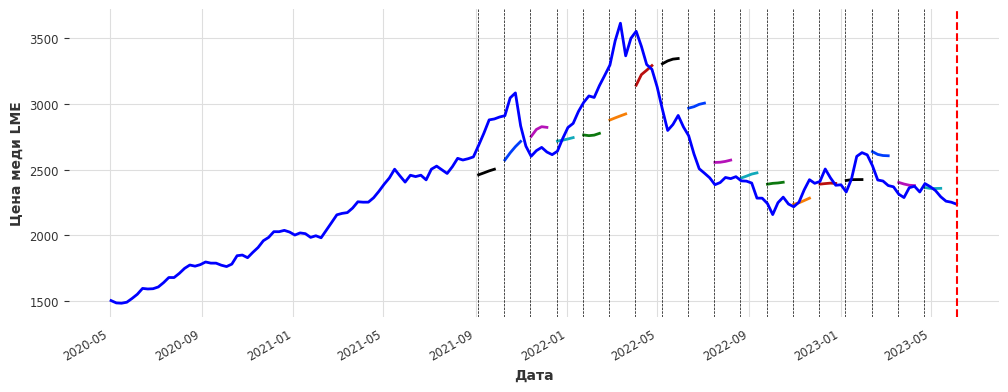

In [51]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in pred_ts.items():
    value.plot(label=None);
    ax.axvline(x=value.start_time() - datetime.timedelta(1), color='black', linestyle='--', linewidth=0.5)
ts[100:].plot(color='blue', label=None)
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
plt.savefig('pic2.png', dpi=400, format='png')

Text(0.5, 0, 'Number of historical forecast')

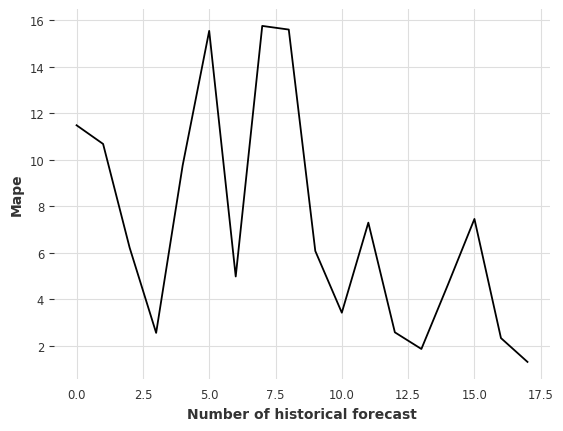

In [52]:
fig, ax = plt.subplots()
ax = sns.lineplot(bt_metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of historical forecast')

### Fit and evaluate without refitting

In [67]:
candidates = ['bloomberg_metals_price_mean_4',
               'ftse_index_std_4',
               'baltic_dry_index_std_9',
               'USD_EUR_rate_std_26']

prediction_curves, out_of_time_metrics_no_refit = evaluation_without_refitting(model_settings=new_best_params,
                                                                               backtest_settings=new_settings_for_backtest,
                                                                               df=df,
                                                                               candidates=candidates
                                                                              )

MAPE: 4.37 +- 1.05


In [68]:
print("Out-of-time MAPE without refit: {:.2f} +- {:.2f}".format(np.mean(out_of_time_metrics_no_refit), np.std(out_of_time_metrics_no_refit)))

Out-of-time MAPE without refit: 4.37 +- 1.05


Text(0.5, 0, 'Number of prediction on the out-of-time set')

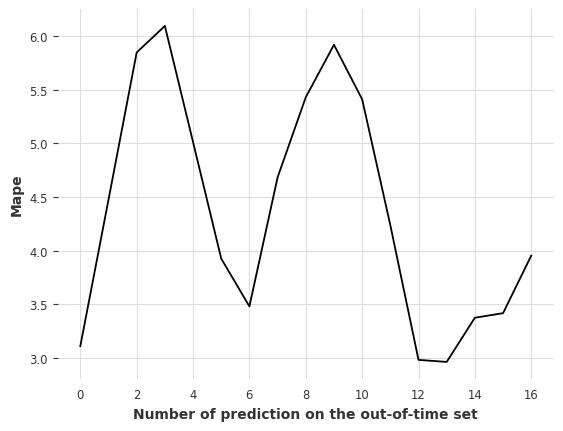

In [69]:
fig, ax = plt.subplots()
ax = sns.lineplot(out_of_time_metrics_no_refit)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

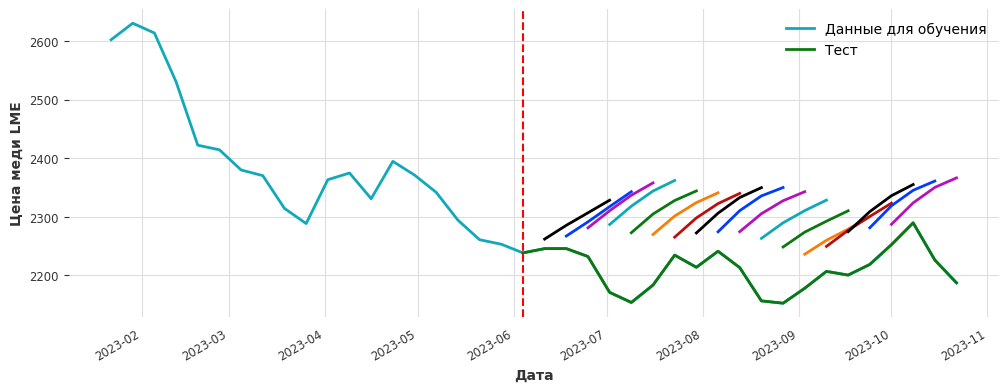

In [76]:
fig, ax = plt.subplots(figsize=(12, 4))
for key, value in prediction_curves.items():
    value.plot(label=None)
data_ts[-2*OUT_OF_TIME_DIM:].plot(label='Данные для обучения')
data_ts[-OUT_OF_TIME_DIM-1:].plot(label='Тест')
ax.set_ylabel('Цена меди LME');
ax.set_xlabel('Дата');
l1 = ax.axvline(x=ts.end_time(), color='r', linestyle='--', linewidth=1.5)
plt.savefig('pic3.png', dpi=400, format='png')

### Evaluate train metrics without refitting

In [60]:
train_metrics = train_metric_evaluation(model_settings=new_best_params,
                                        backtest_settings=new_settings_for_backtest,
                                        df=df,
                                        candidates=candidates)

MAPE: 3.07 +- 2.65


In [61]:
np.mean(train_metrics), np.std(train_metrics)

(3.072123749707574, 2.6451827197896267)

Text(0.5, 0, 'Number of prediction on the out-of-time set')

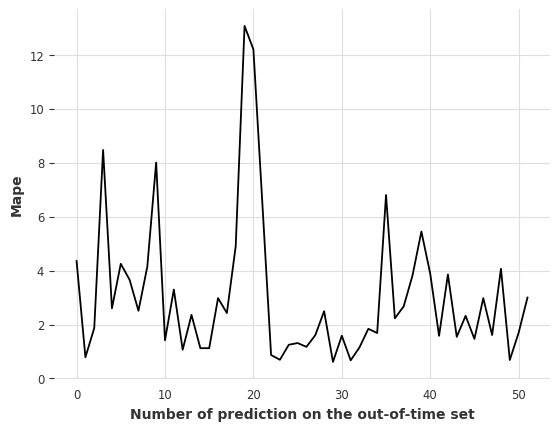

In [62]:
fig, ax = plt.subplots()
ax = sns.lineplot(train_metrics)
ax.set_ylabel('Mape')
ax.set_xlabel('Number of prediction on the out-of-time set')

In [63]:
metrics_dict = {
    "train_mean_mape":np.mean(train_metrics),
    "train_std_mape":np.std(train_metrics),
    "backtest_mean_mape":np.mean(bt_metrics),
    "backtest_std_mape":np.std(bt_metrics),
    "test_mean_mape_no_reffit":np.mean(out_of_time_metrics_no_refit),
    "test_std_mape_no_reffit":np.std(out_of_time_metrics_no_refit)
}
params = new_best_params | new_settings_for_backtest

In [64]:
metrics_dict

{'train_mean_mape': 3.072123749707574,
 'train_std_mape': 2.6451827197896267,
 'backtest_mean_mape': 7.203090712463915,
 'backtest_std_mape': 4.760045540370903,
 'test_mean_mape_no_reffit': 4.372283060417182,
 'test_std_mape_no_reffit': 1.0536864436155948}

In [65]:
params

{'lags': 1,
 'lags_past_covariates': 2,
 'n_estimators': 780,
 'max_depth': 9,
 'min_samples_split': 8,
 'max_features': 1.0,
 'max_samples': 0.6,
 'rolling_window': True,
 'window_size': 156}